# **Job Salary Prediction**
This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting Job Salary.

We're going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

# 1. Problem Definition

Successful models will incorporate some analysis of the impact of including different keywords or phrases, as well as making use of the structured data fields like location, hours or company.  Some of the structured data shown (such as category) is 'inferred' by Adzuna's own processes, based on where an ad came from or its contents, and may not be "correct" but is representative of the real data.

You will be provided with a training data set on which to build your model, which will include all variables including salary.  A second data set will be used to provide feedback on the public leaderboard.  After approximately 6 weeks, Kaggle will release a final data set that does not include the salary field to participants, who will then be required to submit their salary predictions against each job for evaluation.
# 2. Data

The main dataset consists of a large number of rows representing individual job ads, and a series of fields about each job ad

# 3.Evaluation

Our evaluation data set is simply a random subset of ads for which we know the salary, that were not included in the training and public testing datasets.

The evaluation metric for this competition is Mean Absolute Error

Sample submission files can be downloaded from the data page. Submission files should be formatted as follows:

Have a header: "Id,SalaryNormalized"
Contain two columns
Id: Id for the ads in the validation set in sorted order
SalaryNormalized: Your predicted salary for the job ad
# 4. Features

These fields are as follows:

Id - A unique identifier for each job ad

Title - A freetext field supplied to us by the job advertiser as the Title of the job ad.  Normally this is a summary of the job title or role.

FullDescription - The full text of the job ad as provided by the job advertiser.  Where you see ***s, we have stripped values from the description in order to ensure that no salary information appears within the descriptions.  There may be some collateral damage here where we have also removed other numerics.

LocationRaw - The freetext location as provided by the job advertiser.

LocationNormalized - Adzuna's normalised location from within our own location tree, interpreted by us based on the raw location.  Our normaliser is not perfect!

ContractType - full_time or part_time, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

ContractTime - permanent or contract, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

Company - the name of the employer as supplied to us by the job advertiser.

Category - which of 30 standard job categories this ad fits into, inferred in a very messy way based on the source the ad came from.  We know there is a lot of noise and error in this field.

SalaryRaw - the freetext salary field we received in the job advert from the advertiser.

SalaryNormalised - the annualised salary interpreted by Adzuna from the raw salary.  Note that this is always a single value based on the midpoint of any range found in the raw salary.  This is the value we are trying to predict.

SourceName - the name of the website or advertiser from whom we received the job advert. 

All of the data is real, live data used in job ads so is clearly subject to lots of real world noise, including but not limited to: ads that are not UK based, salaries that are incorrectly stated, fields that are incorrectly normalised and duplicate adverts.
Location Tree
This is a supplemental data set that describes the hierarchical relationship between the different Normalised Locations shown in the job data.  It it is likely that there are meaningful relationships between the salaries of jobs in a similar geographical area, for example average salaries in London and the South East are higher than in the rest of the UK.

In [1]:
# Importing some tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
df_train = pd.read_csv('../input/job-salary-prediction/Train_rev1.zip', compression='zip', header=0, sep=',', quotechar='"')
df_train.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


# Data Exploration

In [3]:
df_train.describe()

,Id,SalaryNormalized
count,2.447680e+05,244768.000000
mean,6.970142e+07,34122.577576
std,3.129813e+06,17640.543124
min,1.261263e+07,5000.000000
25%,6.869550e+07,21500.000000
50%,6.993700e+07,30000.000000
75%,7.162606e+07,42500.000000
max,7.270524e+07,200000.000000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [5]:
# Check missing values
df_train.isna().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

In [6]:
# Check for string label 
for label,content in df_train.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Title
FullDescription
LocationRaw
LocationNormalized
ContractType
ContractTime
Company
Category
SalaryRaw
SourceName


In [7]:
# Check for numerical label
for label,content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

Id
SalaryNormalized


In [8]:
# This will turn all of the string value into category values
for label, content in df_train.items():
    if pd.api.types.is_string_dtype(content):
        df_train[label] = content.astype("category").cat.as_ordered()


In [9]:
# Filling missing values
for label,content in df_train.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_train[label+"is_missing"]=pd.isnull(content)
        # Turn categories into numbers and add+1
        df_train[label] = pd.Categorical(content).codes+1

In [10]:
df_train.isna().sum()

Id                              0
Title                           0
FullDescription                 0
LocationRaw                     0
LocationNormalized              0
ContractType                    0
ContractTime                    0
Company                         0
Category                        0
SalaryRaw                       0
SalaryNormalized                0
SourceName                      0
Titleis_missing                 0
FullDescriptionis_missing       0
LocationRawis_missing           0
LocationNormalizedis_missing    0
ContractTypeis_missing          0
ContractTimeis_missing          0
Companyis_missing               0
Categoryis_missing              0
SalaryRawis_missing             0
SourceNameis_missing            0
dtype: int64

# Data Visualization

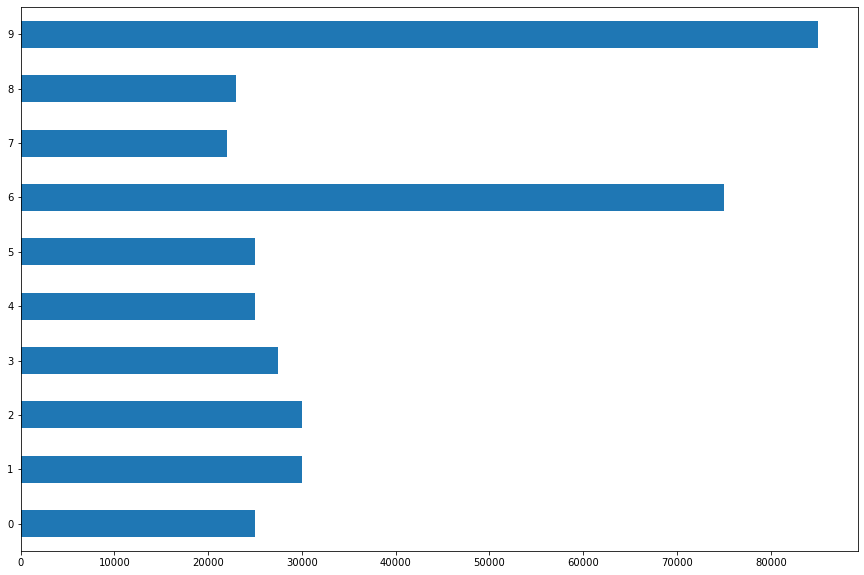

In [11]:
ms = df_train["SalaryNormalized"][:10].plot.barh(figsize=(15,10))

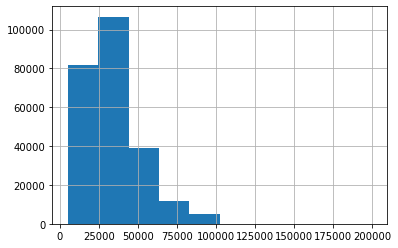

In [12]:
df_train["SalaryNormalized"].hist()

In [13]:
# For more security,copy the train set
df_tmp = df_train.copy()

In [14]:
df_tmp.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,...,Titleis_missing,FullDescriptionis_missing,LocationRawis_missing,LocationNormalizedis_missing,ContractTypeis_missing,ContractTimeis_missing,Companyis_missing,Categoryis_missing,SalaryRawis_missing,SourceNameis_missing
0,12612628,39227,68301,5178,751,0,2,7758,9,21344,...,False,False,False,False,True,False,False,False,False,False
1,12612830,121388,196351,6881,987,0,2,7758,9,32427,...,False,False,False,False,True,False,False,False,False,False
2,12612844,73486,117824,7630,1069,0,2,7758,9,21539,...,False,False,False,False,True,False,False,False,False,False
3,12613049,39228,68300,17183,2310,0,2,7758,9,31840,...,False,False,False,False,True,False,False,False,False,False
4,12613647,85435,157839,17183,2310,0,2,7758,9,21344,...,False,False,False,False,True,False,False,False,False,False


In [15]:
# Split the data into X & y
X = df_tmp.drop("SalaryNormalized",axis=1)
y = df_tmp["SalaryNormalized"]

# Modeling

In [16]:
# # Let's build a machine learning model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1)

# Evaluation

In [17]:
# Evaluate model using mean absolute error
from sklearn.metrics import mean_absolute_error
y_preds_0 = model.predict(X_test)
mae_rf = mean_absolute_error(y_test,y_preds_0)
mae_rf

1734.5571840911873

# Hyerparameter tuning with RandomizedSearchCV

In [18]:
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(42)
grid = {
    "n_estimators":np.arange(10,100,10),
    "max_depth":[None,3,5,10],
    "min_samples_split":np.arange(2,20,2),
    "min_samples_leaf":np.arange(1,20,2),
    "max_features": [0.5,1,"sqrt","auto"],
    "max_samples":[10000,12000,15000,20000]
}
rs_model = RandomizedSearchCV(
RandomForestRegressor(n_jobs=-1,
                     random_state=42),
                    param_distributions = grid,
                     n_iter=5,
                    cv=5,
                    verbose=True)
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000, 12000, 15000,
                                                        20000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [19]:
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_samples': 12000,
 'max_features': 0.5,
 'max_depth': None}

In [20]:
# Choose the best performance
y_preds_rs = rs_model.predict(X_test)
mae_hyp = mean_absolute_error(y_test,y_preds_rs)
mae_hyp,mae_rf

(4656.482273089437, 1734.5571840911873)

# Make predictions

In [21]:
# Importing test data
df_test = pd.read_csv('../input/job-salary-prediction/Test_rev1.zip', compression='zip', header=0, sep=',', quotechar='"')

In [22]:
# Check for missing values
df_test.isna().sum()

Id                        0
Title                     0
FullDescription           0
LocationRaw               0
LocationNormalized        0
ContractType          89450
ContractTime          31761
Company               16261
Category                  0
SourceName                0
dtype: int64

In [23]:
df_test.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
0,11888454,Business Development Manager,The Company: Our client is a national training...,"Tyne Wear, North East",Newcastle Upon Tyne,NaN,permanent,Asset Appointments,Teaching Jobs,cv-library.co.uk
1,11988350,Internal Account Manager,The Company: Founded in **** our client is a U...,"Tyne and Wear, North East",Newcastle Upon Tyne,NaN,permanent,Asset Appointments,Consultancy Jobs,cv-library.co.uk
2,12612558,Engineering Systems Analysts,Engineering Systems Analysts Surrey ****K Loca...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk
3,12613014,CIS Systems Engineering Consultant,CIS Systems Engineering Consultant Bristol So...,"Bristol, South West, South West",Bristol,NaN,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk
4,22454872,CNC Miller / Programmer Fanac,"CNC Miller / Programmer Fanac Fleet, Hampshire...","Fleet, Hampshire",Fleet,NaN,permanent,Gregory Martin International,Manufacturing Jobs,cv-library.co.uk


In [24]:
# Check for string label
for label,content in df_test.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Title
FullDescription
LocationRaw
LocationNormalized
ContractType
ContractTime
Company
Category
SourceName


In [25]:
# Check for numerical label
for label,content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

Id


In [26]:
# This will turn all of the string value into category values
for label, content in df_test.items():
    if pd.api.types.is_string_dtype(content):
        df_test[label] = content.astype("category").cat.as_ordered()
# Filling missing values
for label,content in df_test.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_test[label+"is_missing"]=pd.isnull(content)
        # Turn categories into numbers and add+1
        df_test[label] = pd.Categorical(content).codes+1
X_test.shape,y_test.shape        

((48954, 21), (48954,))

In [27]:
# Reshape X_train & df_test
set(X_train.columns)-set(df_test.columns)

{'SalaryRaw', 'SalaryRawis_missing'}

In [28]:
df_test["SalaryRaw"] = False
df_test["SalaryRawis_missing"] = False

In [29]:
X_train.shape,df_test.shape

((195814, 21), (122463, 21))

In [30]:
# Make predictions
y_preds = model.predict(df_test)

In [31]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["Id"] = df_test["Id"]
df_preds["SalaryNormalized"] = y_preds
df_preds.head()
df_preds.to_csv(".//Submission.csv",index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the **target variable** (SalaryNormalized).

In [32]:
# Find feature importance of our best model
model.feature_importances_

array([1.47933652e-02, 1.46703692e-02, 1.49101146e-02, 1.03557095e-02,
       7.51412203e-03, 2.44518495e-02, 5.90309274e-02, 1.65997379e-02,
       4.19170494e-02, 7.02351337e-01, 6.68815984e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.43994083e-03,
       2.35185421e-02, 1.53749658e-03, 0.00000000e+00, 0.00000000e+00,
       2.78405659e-05])

In [33]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

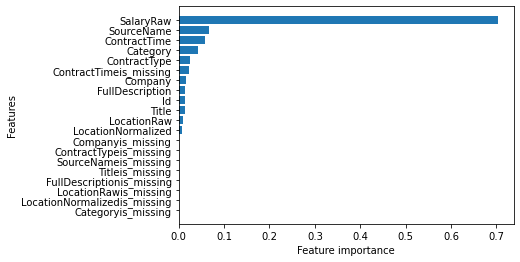

In [34]:
plot_features(X_train.columns,model.feature_importances_)

In [35]:
df_tmp["SalaryRaw"].value_counts()

61968    1923
49198     868
55105     834
59122     764
44773     742
         ... 
37341       1
35294       1
33247       1
96736       1
2049        1
Name: SalaryRaw, Length: 97286, dtype: int64